In [6]:
import pandas as pd
import pycountry

# 1. Load the two pieces
music_df = pd.read_csv('country_music_scores.csv')
happiness_df = pd.read_csv('world_happiness_2024.csv', sep=None, engine='python')

# 2. Fix Country Names (US -> United States)
def get_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

music_df['Country_Name'] = music_df['Country_Code'].apply(get_name)

# 3. Merge them
# Find the happiness country column automatically
happ_col = [c for c in happiness_df.columns if 'country' in c.lower()][0]

final_df = pd.merge(
    music_df, 
    happiness_df, 
    left_on='Country_Name', 
    right_on=happ_col,
    how='inner'
)

# 4. SAVE IT
final_df.to_csv('final_project_dataset.csv', index=False)

print("SUCCESS!")
print(f"Created 'final_project_dataset.csv' with {len(final_df)} rows.")

SUCCESS!
Created 'final_project_dataset.csv' with 95 rows.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Set the visual style for all plots
sns.set(style="whitegrid")

filename = 'final_project_dataset.csv'

try:
    final_df = pd.read_csv(filename)
    print(f"Successfully loaded {len(final_df)} countries.")
    
    # Music Sentiment
    final_df['Avg_Music_Sentiment'] = pd.to_numeric(final_df['Avg_Music_Sentiment'], errors='coerce')
    
    # Identify Happiness Column dynamically
    happiness_col = 'Ladder score' 
    if happiness_col not in final_df.columns:
        for col in final_df.columns:
            if 'ladder' in col.lower() or 'score' in col.lower():
                happiness_col = col
                break
    
    # Happiness Column
    if final_df[happiness_col].dtype == 'object':
         final_df[happiness_col] = final_df[happiness_col].str.replace(',', '.')
    final_df[happiness_col] = pd.to_numeric(final_df[happiness_col], errors='coerce')
    
    # Drop rows with missing values
    final_df = final_df.dropna(subset=['Avg_Music_Sentiment', happiness_col])
    
    print(f"Using Target Variable: '{happiness_col}'")
    print(f"Data ready for analysis. Rows remaining: {len(final_df)}")

except FileNotFoundError:
    print(f"ERROR: Could not find '{filename}'. Check the file name or path.")

Successfully loaded 95 countries.
Using Target Variable: 'Ladder score'
Data ready for analysis. Rows remaining: 95


## T-Test

In [8]:
# Median happiness score
median_happiness = final_df[happiness_col].median()

# New category column based on the median
final_df['Happiness_Category'] = final_df[happiness_col].apply(
    lambda x: 'High Happiness' if x >= median_happiness else 'Low Happiness'
)

print(f"Median Happiness Score: {median_happiness}")
print("New column 'Happiness_Category' created.")
print(final_df[['Country', happiness_col, 'Happiness_Category']].head())

Median Happiness Score: 6.0598
New column 'Happiness_Category' created.
       Country  Ladder score Happiness_Category
0  Philippines        6.0476      Low Happiness
1    Sri Lanka        3.8981      Low Happiness
2  New Zealand        7.0292     High Happiness
3      Georgia        5.1847      Low Happiness
4     Pakistan        4.6567      Low Happiness


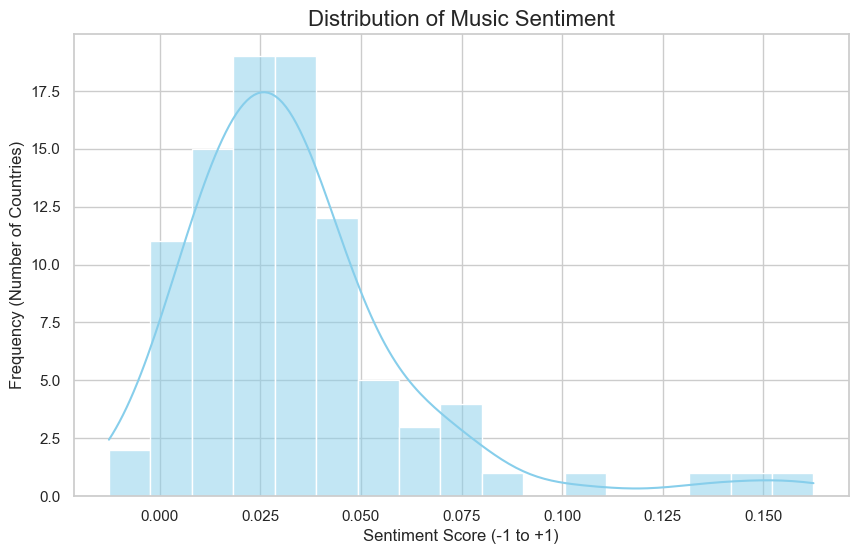

In [13]:
# Set the figure size for a single large plot
plt.figure(figsize=(10, 6))

# Create the Histogram
sns.histplot(final_df['Avg_Music_Sentiment'], kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Music Sentiment', fontsize=16)
plt.xlabel('Sentiment Score (-1 to +1)', fontsize=12)
plt.ylabel('Frequency (Number of Countries)', fontsize=12)

# Display the plot
plt.show()

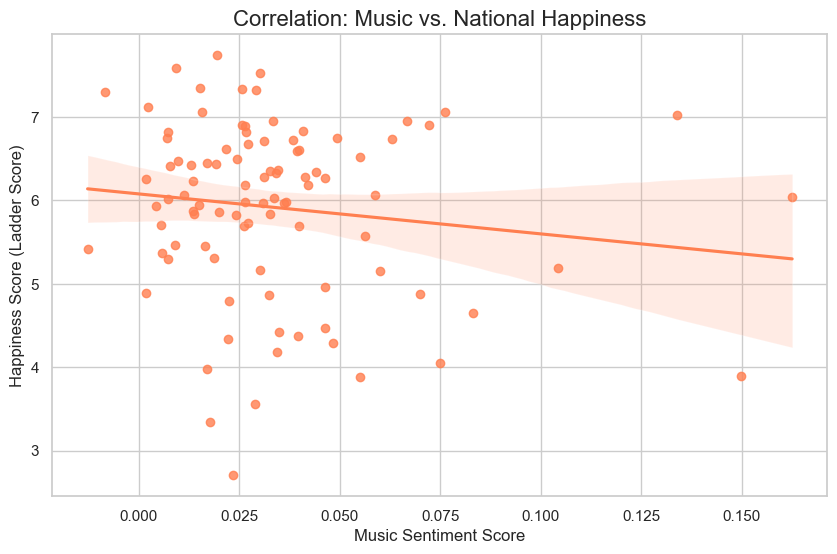

In [15]:
# Set the figure size for a single large plot
plt.figure(figsize=(10, 6))

# Create the Scatter Plot with Regression Line
sns.regplot(data=final_df, x='Avg_Music_Sentiment', y=happiness_col, color='coral')

# Add titles and labels
plt.title('Correlation: Music vs. National Happiness', fontsize=16)
plt.xlabel('Music Sentiment Score', fontsize=12)
plt.ylabel('Happiness Score (Ladder Score)', fontsize=12)

# Display the plot
plt.show()

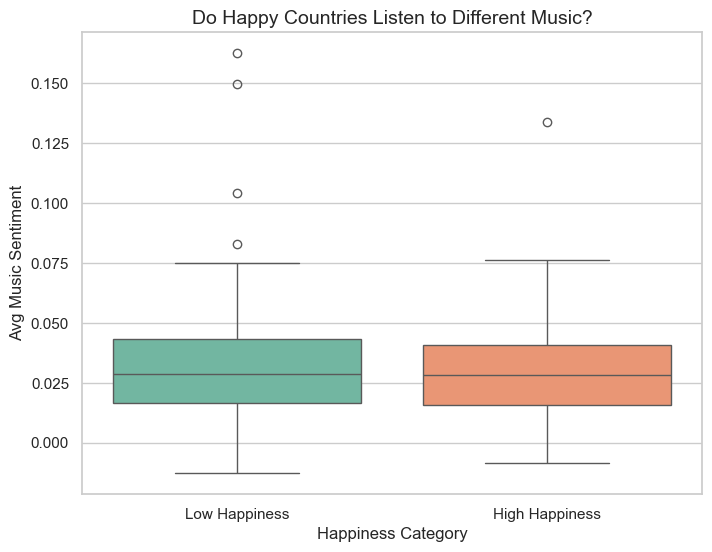

In [17]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='Happiness_Category', 
    y='Avg_Music_Sentiment', 
    data=final_df, 
    palette="Set2", 
    hue='Happiness_Category', 
    legend=False
)

plt.title('Do Happy Countries Listen to Different Music?', fontsize=14)
plt.xlabel('Happiness Category')
plt.ylabel('Avg Music Sentiment')
plt.show()

In [18]:
# Shapiro-Wilk test for normality
stat_shapiro, p_shapiro = stats.shapiro(final_df['Avg_Music_Sentiment'])
is_normal = p_shapiro > 0.05

print(f"--- Normality Test Results ---")
print(f"P-value: {p_shapiro:.4f}")
if is_normal:
    print("Result: Data is Normal. We will use Pearson Correlation and T-Test.")
else:
    print("Result: Data is NOT Normal. We will use Spearman Correlation and Mann-Whitney U Test.")

--- Normality Test Results ---
P-value: 0.0000
Result: Data is NOT Normal. We will use Spearman Correlation and Mann-Whitney U Test.


In [19]:
print("--- FINAL HYPOTHESIS TEST RESULTS ---\n")

# TEST 1: Correlation (Relationship Strength)
if is_normal:
    corr_coef, p_val_corr = stats.pearsonr(final_df['Avg_Music_Sentiment'], final_df[happiness_col])
    test_name = "Pearson"
else:
    corr_coef, p_val_corr = stats.spearmanr(final_df['Avg_Music_Sentiment'], final_df[happiness_col])
    test_name = "Spearman (Rank)"

print(f"[1] Correlation Test ({test_name}):")
print(f"    Coefficient: {corr_coef:.4f}")
print(f"    P-Value: {p_val_corr:.4f}")
if p_val_corr < 0.05:
    print("    -> SIGNIFICANT RELATIONSHIP found.")
else:
    print("    -> No significant linear relationship found.")


# TEST 2: Group Comparison (Difference of Means)
group_high = final_df[final_df['Happiness_Category'] == 'High Happiness']['Avg_Music_Sentiment']
group_low = final_df[final_df['Happiness_Category'] == 'Low Happiness']['Avg_Music_Sentiment']

if is_normal:
    t_stat, p_val_group = stats.ttest_ind(group_high, group_low)
    test_type = "Independent T-Test"
else:
    t_stat, p_val_group = stats.mannwhitneyu(group_high, group_low)
    test_type = "Mann-Whitney U Test"

print(f"\n[2] Group Comparison Test ({test_type}):")
print(f"    Statistic: {t_stat:.4f}")
print(f"    P-Value: {p_val_group:.4f}")

if p_val_group < 0.05:
    print("    -> SIGNIFICANT DIFFERENCE found between Happy and Less Happy countries.")
else:
    print("    -> No significant difference found between the groups.")

--- FINAL HYPOTHESIS TEST RESULTS ---

[1] Correlation Test (Spearman (Rank)):
    Coefficient: -0.0912
    P-Value: 0.3795
    -> No significant linear relationship found.

[2] Group Comparison Test (Mann-Whitney U Test):
    Statistic: 1113.0000
    P-Value: 0.9140
    -> No significant difference found between the groups.
